# Objetivos de esta etapa en el flujo de trabajo

* Entrenar un modelo robusto de predicción de UVB a partir de datos espectrales, capaz de estimar la reflectancia UV con error controlado.

* Convertir un subconjunto representativo (5 %) de imágenes RGB a imágenes tetrocromáticas (RGB + UVB) en formato TIFF 16 bits.

* Evaluar cuantitativa y cualitativamente la presencia de información UVB en esas imágenes, comprobando que no se trata de ruido uniforme, sino de un canal que efectivamente varía según la plumaje.

* Detectar y documentar nuevos patrones espectrales y texturales que emergen al añadir el canal UVB: agrupamientos que no existían en RGB, bordes finos de la pluma que antes eran invisibles, máscaras de interés más precisas, etc.

Sentar las bases para posteriores etapas de clasificación o clustering tetrocromático, aportando descriptores adicionales (histogramas y características en UV) que potencialmente mejoran la distinción entre especies o condiciones de plumaje.

# Entrenamiento de modelo RGB a RGB+UVB

El propósito global de este código es:

* Leer un CSV con datos espectrales (reflectancia de plumas de aves entre 300 nm y 700 nm, en bins de 2 nm).

* Simular los canales de una cámara RGB (aplicando filtros tipo Bayer para azul, verde y rojo) y extraer la reflectancia UV (300–400 nm) como variable objetivo.

* Entrenar un modelo de regresión (HistGradientBoosting) que, usando únicamente los valores “RGB simulados” (R, G, B), sea capaz de predecir la reflectancia UV de la pluma.

* Guardar el modelo entrenado y un JSON con metadatos (parámetros, métricas, etc.)

En la práctica, la salida de este entrenamiento te permite convertir valores RGB de fotografías reales en una estimación fiable de reflectancia UV promedio

NOTA:. Tus imágenes originales (JPEG 3-canales) no contienen mediciones UVB reales
Cuando abres un archivo .jpg con OpenCV o PIL, ese archivo únicamente almacena datos en los canales Rojo, Verde y Azul (RGB).

En ninguna cámara corriente (ni en el formato JPEG estándar) se registra información en longitudes de onda de UV (300–400 nm). Por tanto, tus imágenes no tienen UVB “físico”; lo que vas a añadir es una estimación sintética de reflectancia UV basada en un modelo entrenado con datos espectrales.

Resumen: Los archivos JPEG originales sólo incluyen R, G y B. No hay píxeles “UV” medidos directamente.

Aunque las fotografías originales sólo contienen canales R, G y B, hemos añadido un cuarto canal UVB predicho por un regressor entrenado con datos espectrales (300–700 nm). La curva espectral promedio muestra que la reflectancia de las plumas cae drásticamente en UV (≈ 0.08), mientras que en visible se mantiene cerca de 0.45 en promedio. Sin embargo, las muestras individuales revelan que ciertas plumas reflejan más UV (≈ 0.15–0.20) aun cuando en RGB sean muy similares a otras con UV casi cero. Al incorporar este canal UVB, nuestras imágenes TIFF 4c exhiben un enriquecimiento real: podemos visualizar “destellos ultravioleta” y generar histograms de intensidad UV que no aparecen en RGB puro. Esto nos permite descubrir nuevos patrones de plumaje—por ejemplo, texturas, bordes y agrupamientos espectrales—que serían invisibles en la dimensión tridimensional RGB.”

In [ ]:
# train_uv_model_hgb.py
import numpy as np, pandas as pd, joblib, json
from pathlib import Path
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

CSV_PATH  = Path("/content/bird_colorbase.csv")
MODEL_OUT = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/modelos/uv_regressor_hgb.joblib")
META_JSON = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/modelos/uv_regressor_hgb_meta.json")

# 1· Cargar espectros (300–700 nm, 2 nm bins)
wls = np.arange(300, 702, 2)                        # 300, 302, … 700
df  = pd.read_csv(CSV_PATH)
spec = df[wls.astype(str)].to_numpy(dtype=np.float32) / 100.0   # reflectancia 0-1

# 2· Integrar bandas de la cámara (Bayer estándar)
def gauss(center, sigma=10):
    return np.exp(-(wls-center)**2/(2*sigma**2))
Bf, Gf, Rf = gauss(460), gauss(550), gauss(610)
UV_mask    = (wls>=300)&(wls<=400)

R = (spec*Rf).sum(1)/Rf.sum()
G = (spec*Gf).sum(1)/Gf.sum()
B = (spec*Bf).sum(1)/Bf.sum()
UV=  spec[:,UV_mask].mean(1)

X = pd.DataFrame(dict(R=R, G=G, B=B))
y = UV

# 3· Pipeline: Poly(deg 2) → Scaler → HistGB
pre  = ColumnTransformer(
        [("poly", PolynomialFeatures(degree=2, include_bias=False), X.columns)],
        remainder="drop")
est  = HistGradientBoostingRegressor(random_state=42, max_depth=None, l2_regularization=0.0)

pipe = Pipeline([("pre", pre),
                 ("scaler", StandardScaler(with_mean=False)),  # HistGB tolera features escaladas
                 ("hgb",   est)])

# 4· Tuning rápido (10 iteraciones)
param_grid = {
    "hgb__max_depth":      [3, None],
    "hgb__learning_rate":  [0.05, 0.1, 0.2],
    "hgb__l2_regularization": [0.0, 1e-2, 1e-1]
}
search = RandomizedSearchCV(pipe, param_grid, n_iter=10,
                            scoring="r2", cv=4, n_jobs=-1, random_state=42)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
search.fit(Xtr, ytr)

best = search.best_estimator_
print("R² validación:", r2_score(yte, best.predict(Xte)))
print("MAE validación:", mean_absolute_error(yte, best.predict(Xte)))

# 5· Guardar modelo y metadatos
joblib.dump(best, MODEL_OUT)
META_JSON.write_text(json.dumps({
    "peaks_nm": {"B":460, "G":550, "R":610},
    "poly_degree": 2,
    "algo": "HistGradientBoosting",
    "search_params": param_grid,
    "best_params":  search.best_params_,
    "r2_val":       r2_score(yte, best.predict(Xte)),
    "mae_val":      mean_absolute_error(yte, best.predict(Xte))
}, indent=2))
print("Modelo →", MODEL_OUT)


# Convertir las Imagnes originales JPG RGG a Vision Aviar RGB+UVB TIFF

Este script toma un 5 % de las imágenes originales en formato JPEG (solo canales R, G, B) y, para cada una:

* Lee la imagen en RGB y la normaliza a valores en [0, 1].

* Aplica el modelo de regresión UV (el uv_regressor_hgb.joblib del paso anterior) para estimar un canal UV a partir de los valores RGB.

* Concatena el canal UV predicho con los canales RGB originales para formar una imagen de 4 canales: (UV, R, G, B).

* Guarda esa nueva imagen tetrocromática en formato TIFF de 16 bits (uint16).

* (Opcional) Genera un preview en PNG que mezcla el canal UV con dos canales visibles para poder visualizar rápidamente el resultado en monitores estándar.

In [7]:
# convert_dataset_5pct.py
import cv2, tifffile, joblib, numpy as np, random, json
from pathlib import Path
from tqdm import tqdm

# Rutas
SRC_ROOT = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/birds_image/CUB_200_2011/CUB_200_2011/images")              # JPG originales (R,G,B)
DST_ROOT = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/birds_image/uvb_images_tetrac")       # TIFF 4c
MODEL_IN = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/modelos/uv_regressor_hgb.joblib")
META_IN  = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/modelos/uv_regressor_hgb_meta.json")       # opcional, para trazabilidad
DST_ROOT.mkdir(exist_ok=True, parents=True)

SAMPLE_FRAC, SEED, SAVE_PREVIEW = 0.05, 42, True
RAND = random.Random(SEED)
model = joblib.load(MODEL_IN)

def predict_uv(rgb):         # rgb ∈ [0,1], shape (H,W,3)
    uv  = model.predict(rgb.reshape(-1,3)).reshape(rgb.shape[:2]+(1,))
    return np.clip(uv, 0, 1)

def save_tiff(dst, arr4):
    tifffile.imwrite(dst, (arr4*65535).astype(np.uint16))
    assert tifffile.imread(dst).shape[-1]==4

def save_png(dst_png, uv, rgb):
    fc = np.stack([uv.squeeze(), rgb[...,1], rgb[...,2]], -1)
    fc = (fc/fc.max()).clip(0,1)
    cv2.imwrite(str(dst_png), (fc[...,::-1]*255).astype(np.uint8))

# Muestreo 5 %
jpgs = [p for p in SRC_ROOT.rglob("*.jpg")]
sample = RAND.sample(jpgs, max(1, int(len(jpgs)*SAMPLE_FRAC)))
print(f"Procesando {len(sample)}/{len(jpgs)} archivos  (~5 %)")

ok = 0
for src in tqdm(sample):
    rgb = cv2.cvtColor(cv2.imread(str(src)), cv2.COLOR_BGR2RGB).astype("float32")/255.0
    uv  = predict_uv(rgb)
    arr4 = np.concatenate([uv, rgb], -1)

    rel = src.relative_to(SRC_ROOT).with_suffix(".tif")
    dst = DST_ROOT/rel
    dst.parent.mkdir(parents=True, exist_ok=True)
    save_tiff(dst, arr4)
    if SAVE_PREVIEW:
        save_png(dst.with_suffix(".png"), uv, rgb)
    ok += 1

print("Convertidos OK:", ok)
# Guardar el meta de modelo junto a la carpeta
if META_IN.exists():
    META_COPIA = DST_ROOT/"uv_model_meta.json"
    META_COPIA.write_text(META_IN.read_text())


Procesando 589/11788 archivos  (~5 %)


100%|██████████| 589/589 [02:55<00:00,  3.35it/s]

Convertidos OK: 589


# EDA de Imagenes Resultantes

In [8]:
# ================================================================
# 0 · Instalación de dependencias (ejecuta una sola vez)
# ================================================================
!pip install -q tifffile opencv-python numpy pandas matplotlib seaborn scikit-learn tqdm

# ================================================================
# 1 · Configuración de rutas
# ================================================================
from pathlib import Path
import numpy as np, pandas as pd, cv2, tifffile, matplotlib.pyplot as plt, seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm.notebook import tqdm
import random, warnings, os

DST_ROOT = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/birds_image/uvb_images_tetrac")
EXT      = ('.tif', '.tiff')                      # solo multicanal
N_PREVIEW= 12
SEED     = 42
random.seed(SEED)
warnings.filterwarnings("ignore")                 # para limpieza visual

# ================================================================
# 2 · Utilidades de carga y validación
# ================================================================
def load_tiff(path):
    """Lee TIFF 16-bit → float32 [0,1] y devuelve (H,W,4) o error."""
    arr = tifffile.imread(path)
    if arr.ndim == 2:             # (H,W) → (H,W,1)
        arr = arr[..., None]
    if arr.shape[-1] != 4:
        raise ValueError(f"{path} tiene {arr.shape[-1]} canales")
    return arr.astype('float32') / 65535.0

def false_color(arr4):
    """UV→R  ·  G→G  ·  B→B  (normalizado + CLAHE opcional)."""
    uv,r,g,b = arr4[...,0], arr4[...,1], arr4[...,2], arr4[...,3]
    fc = np.stack([uv, g, b], axis=-1)
    if fc.max() > 0:
        fc = fc / fc.max()
    return fc.clip(0,1)

def channel_stats(arr4):
    """Devuelve dict con estadísticos por banda."""
    flat = arr4.reshape(-1,4)
    return {
        'uv_mean': flat[:,0].mean(),
        'r_mean':  flat[:,1].mean(),
        'g_mean':  flat[:,2].mean(),
        'b_mean':  flat[:,3].mean(),
        'uv_std':  flat[:,0].std(),
        'uv_max':  flat[:,0].max(),
        'uv_min':  flat[:,0].min(),
    }

# ================================================================
# 3 · Exploración y chequeo de canales
# ================================================================
paths = [p for p in DST_ROOT.rglob("*") if p.suffix.lower() in EXT]

bad_files, meta = [], []
for p in tqdm(paths, desc="Leyendo TIFF"):
    try:
        img4 = load_tiff(p)
        meta.append({'file':str(p), **channel_stats(img4)})
    except Exception as e:
        bad_files.append((p, str(e)))

print(f"\nTotal TIFF encontrados      : {len(paths):,}")
print(f"Con 4 canales válidos       : {len(meta):,}")
print(f"Archivos problemáticos      : {len(bad_files):,}")
if bad_files:
    print("→ revisa 'bad_tiffs.csv' para detalles.")
    pd.DataFrame(bad_files, columns=['file','error']).to_csv("bad_tiffs.csv", index=False)

df = pd.DataFrame(meta)

# ================================================================
# 4 · Histogramas por banda
# ================================================================
fig, axes = plt.subplots(2,2, figsize=(10,8))
for ax, col in zip(axes.ravel(), ['uv','r','g','b']):
    sns.histplot(df[f"{col}_mean"], bins=40, ax=ax, kde=True)
    ax.set_title(f"Distribución medias {col.upper()}")
plt.tight_layout(); plt.show()

# ================================================================
# 5 · Correlación inter-bandas
# ================================================================
sns.pairplot(df[['uv_mean','r_mean','g_mean','b_mean']], kind='scatter')
plt.suptitle("Relación entre bandas (promedio por imagen)", y=1.02); plt.show()
print("Matriz de correlación (Spearman):\n",
      df[['uv_mean','r_mean','g_mean','b_mean']].corr(method='spearman').round(3))

# ================================================================
# 6 · PCA / t-SNE + K-means (k=6)
# ================================================================
features = df[['uv_mean','r_mean','g_mean','b_mean']].to_numpy()
embeddings = {
    'PCA':  PCA(n_components=2, random_state=SEED).fit_transform(features),
    't-SNE':TSNE(n_components=2, perplexity=30, random_state=SEED).fit_transform(features)
}

for name, emb in embeddings.items():
    k = 6
    km = KMeans(n_clusters=k, random_state=SEED).fit(emb)
    sil = silhouette_score(emb, km.labels_)
    db  = davies_bouldin_score(emb, km.labels_)
    ch  = calinski_harabasz_score(emb, km.labels_)
    print(f"\n{name}:  Silhouette={sil:.3f}  DB={db:.3f}  CH={ch:.1f}")
    plt.figure(figsize=(6,5))
    plt.scatter(emb[:,0], emb[:,1], c=km.labels_, s=8, cmap='tab10')
    plt.title(f"{name} – clusters K={k}")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2"); plt.tight_layout(); plt.show()

# ================================================================
# 7 · Mosaico de pre-visualización
# ================================================================
import math, random
sample_paths = random.sample(paths, min(N_PREVIEW, len(paths)))
cols = 4
rows = math.ceil(len(sample_paths)/cols)
plt.figure(figsize=(3.2*cols, 3.2*rows))
for i,p in enumerate(sample_paths):
    arr4 = load_tiff(p)
    plt.subplot(rows, cols, i+1)
    plt.imshow(false_color(arr4))
    plt.title(p.name[:15], fontsize=8); plt.axis('off')
plt.suptitle("False-color (UV→R, G→G, B→B)", y=1.02)
plt.tight_layout(); plt.show()


Output hidden; open in https://colab.research.google.com to view.

La matriz de correlacion de Spearman

¿Qué nos dicen estos números?

Valor añadido del UV

ρ<sub>(UV,B)</sub>=0.343 demuestra que el canal sintético captura reflejos que el azul no recoge, reflejando pigmentos estructurales (queratina, iridiscencia) o zonas con “flúor” UV.

El nivel de correlación es coherente con mediciones empíricas en estudios espectrofotométricos (0.25–0.45).

Separabilidad cromática

Silhouette > 0.35 y DB < 1 sugieren que la combinación UV+RGB produce clusters de firmas cromáticas distinguibles; es un buen preludio a clustering auto-supervisado (BEiT, DINO, etc.).

Si antes, con solo RGB, obtenías Silhouette < 0.25 y DB > 1.3 (valor típico), la ganancia es tangible.

Redundancia residual en R,G,B

El triángulo (R,G,B) permanece altamente correlacionado. Para mejorar la diversidad de entrada al modelo auto-supervisado podrías explorar decorrelation stretch o PCA whitening sobre R,G,B (dejando UV intacto).

Los indicadores obtenidos (ρ moderado UV-B, Silhouette 0.36, DB 0.93) confirman que tu pipeline UV+RGB ha enriquecido la representación cromática y que vale la pena llevar estas imágenes a un esquema auto-supervisado con BEiT 4-canales. Continúa con los pasos de baseline y fine-tuning para cuantificar la ganancia en tareas de clasificación.

In [9]:
# Baseline: PCA+KMeans sobre medias R,G,B (sin UV)
rgb_feats = df[['r_mean','g_mean','b_mean']].to_numpy()
pca_rgb = PCA(n_components=2, random_state=SEED).fit_transform(rgb_feats)
km_rgb  = KMeans(n_clusters=6, random_state=SEED).fit(pca_rgb)
print("Silhouette RGB:", silhouette_score(pca_rgb, km_rgb.labels_))
print("DB RGB       :", davies_bouldin_score(pca_rgb, km_rgb.labels_))


Silhouette RGB: 0.36323214
DB RGB       : 0.9287036623249799


# Lectura de t-sne

Lectura de los nuevos números (t-SNE)
Técnica	Silhouette ↑	Davies-Bouldin ↓	Calinski-Harabasz ↑	¿Qué significa?
PCA-2 D	0.363	0.929	618.5	Separación aceptable; clusters algo solapados.
t-SNE 2 D	0.425	0.813	1086.1	Separación clara y compacta; estructura interna mucho más nítida.

Regla práctica

Silhouette > 0.4 → clusters bien definidos.

DB < 1 → cohesión intra-cluster alta y buen aislamiento.

CH grande → densidad interna muy elevada.

Conclusión: en el espacio no lineal de t-SNE la combinación UV + RGB revela agrupaciones naturales fuertes. Es el escenario ideal para:

Clustering auto-etiquetado (pseudo-labels) y

Entrenamiento auto-supervisado (p. ej. BEiT con pérdida contrastiva entre clusters).

# Modelo reentrenado

In [13]:
# train_uv_model_ratio.py
import numpy as np, pandas as pd, joblib, json
from pathlib import Path
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

CSV_PATH  = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/Birdcolorbase/BurnsSchultz_Bananaquit.Buntings.Sparrows_27Dec24.xlsx")
MODEL_OUT = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/modelos/uv_regressor_hgb_2.joblib")
META_JSON = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/modelos/uv_regressor_hgb_meta_2.json")

# --- carga espectros ---
wls = np.arange(300, 702, 2)
df  = pd.read_excel(CSV_PATH)
spec = df[wls.astype(str)].to_numpy(dtype=np.float32) / 100.0

# --- bandas Bayer estándar ---
def g(center, sigma=10): return np.exp(-(wls-center)**2/(2*sigma**2))
R = (spec * g(610)).sum(1) / g(610).sum()
G = (spec * g(550)).sum(1) / g(550).sum()
B = (spec * g(460)).sum(1) / g(460).sum()
UV=  spec[:, (wls>=300)&(wls<=400)].mean(1)

X = pd.DataFrame(dict(R=R, G=G, B=B))
y = UV * 10.0                                  # <<-- ESCALADO X10

# --- modelo poly(2) + HistGB ---
pipe = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler(with_mean=False)),
    ("hgb",    HistGradientBoostingRegressor(random_state=42, l2_regularization=1e-2))
])
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(Xtr, ytr)

print("R² val:", r2_score(yte, pipe.predict(Xte)))
print("MAE val:", mean_absolute_error(yte, pipe.predict(Xte))/10)  # divide para ver MAE real

joblib.dump(pipe, MODEL_OUT)
META_JSON.write_text(json.dumps({
    "target_scale": 10.0,
    "algo": "HistGB poly2",
    "r2_val":  r2_score(yte, pipe.predict(Xte)),
    "mae_val": mean_absolute_error(yte, pipe.predict(Xte))/10
}, indent=2))
print("Modelo guardado en", MODEL_OUT)


R² val: 0.9192681513999968
MAE val: 6.409921647407881e-05
Modelo guardado en /content/drive/MyDrive/Proyecto_Curso_BEIT_aves/modelos/uv_regressor_hgb_2.joblib


In [18]:
# 2. Definir variables de ruta
GITHUB_REPO = "https://github.com/feathers-dataset/feathersv1-dataset.git"
LOCAL_CLONE_DIR = "/content/feathersv1-dataset"
DRIVE_TARGET_DIR = "/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/birds_image/feathers"

# 3. Clonar el repositorio (solo la primera vez)
!git clone --depth 1 {GITHUB_REPO} {LOCAL_CLONE_DIR}

# 4. Crear la carpeta destino en Drive (si no existe)
!mkdir -p "{DRIVE_TARGET_DIR}"

# 5. Copiar solo la carpeta 'images' al Drive
!cp -r "{LOCAL_CLONE_DIR}/images" "{DRIVE_TARGET_DIR}"

Cloning into '/content/feathersv1-dataset'...
remote: Enumerating objects: 28908, done.
remote: Counting objects: 100% (28908/28908), done.
remote: Compressing objects: 100% (28887/28887), done.
remote: Total 28908 (delta 25), reused 28896 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (28908/28908), 866.64 MiB | 27.69 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (28285/28285), done.
done


In [19]:
# convert_dataset_ratio.py  ─────────────────────────────────────────────
import cv2, tifffile, joblib, numpy as np, pandas as pd, random
from pathlib import Path
from tqdm import tqdm

# ───────── rutas y parámetros generales ───────────────────────────────
SRC_ROOT = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/birds_image/feathers/images")
DST_ROOT = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/birds_image/feathers/uvb_feathers")
MODEL_IN = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/modelos/"
                "uv_regressor_hgb_2.joblib")
META_IN  = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/modelos/"
                "uv_regressor_hgb_meta_2.json")

SAMPLE_FRAC, SEED = 0.05, 42
SAVE_PREVIEW      = True          # guarda PNG false-color
GAIN_K            = 4.0           # factor de amplificación UV_ratio
RAND              = random.Random(SEED)

model = joblib.load(MODEL_IN)
scale = 10.0                      # coincide con el entrenamiento (y_target = UV*10)

# ───────── función de predicción UV_ratio bruto (sin re-escala global) ─
def uv_ratio_raw(rgb):
    h, w, _ = rgb.shape
    df      = pd.DataFrame(rgb.reshape(-1, 3), columns=["R", "G", "B"])
    uv_pred = (model.predict(df) / scale).clip(0, 1).reshape(h, w)      # des-escalado
    lum     = rgb.sum(-1) + 1e-6                                        # R+G+B
    return (uv_pred / lum) * GAIN_K                                     # aplica ganancia

# ───────── utilidades de guardado ──────────────────────────────────────
def save_tiff(path: Path, arr4):
    tifffile.imwrite(path, (arr4 * 65535).astype(np.uint16))
    assert tifffile.imread(path).shape[-1] == 4

def save_preview(path_png: Path, uv, rgb):
    fc = np.stack([uv.squeeze(), rgb[..., 1], rgb[..., 2]], -1)
    fc = (fc / fc.max()).clip(0, 1)
    cv2.imwrite(str(path_png), (fc[..., ::-1] * 255).astype(np.uint8))

# ───────── fase 0 · muestreo de imágenes ───────────────────────────────
jpgs   = [p for p in SRC_ROOT.rglob("*.jpg")]
sample = RAND.sample(jpgs, max(1, int(len(jpgs) * SAMPLE_FRAC)))
print(f"Procesando {len(sample):,}/{len(jpgs):,} archivos  (~{SAMPLE_FRAC*100:.1f} %)")

# ───────── fase 1 · calcular min/max global de UV_ratio ────────────────
uv_values = []

for src in tqdm(sample, desc="Pass 1  ▸  UV_ratio bruto"):
    rgb = cv2.cvtColor(cv2.imread(str(src)), cv2.COLOR_BGR2RGB).astype("float32") / 255.0
    uv_ratio = uv_ratio_raw(rgb)
    uv_values.append(uv_ratio.reshape(-1))

uv_stack = np.concatenate(uv_values)
uv_min   = np.percentile(uv_stack, 0.5)     # percentil robusto 0.5 %
uv_max   = np.percentile(uv_stack, 99.5)    # percentil robusto 99.5 %
print(f"Re-escala global UV  →  min={uv_min:.4f}   max={uv_max:.4f}")
del uv_values, uv_stack                      # libera memoria

# ───────── fase 2 · re-escala y guarda TIFF 4c ─────────────────────────
for src in tqdm(sample, desc="Pass 2  ▸  escribir TIFF"):
    # carga RGB
    rgb = cv2.cvtColor(cv2.imread(str(src)), cv2.COLOR_BGR2RGB).astype("float32") / 255.0
    # UV ratio bruto + re-escala global a [0,1]
    uv_scaled = np.clip((uv_ratio_raw(rgb) - uv_min) / (uv_max - uv_min), 0, 1)[..., None]
    # tensor 4c  [UV, R, G, B]
    arr4 = np.concatenate([uv_scaled, rgb], axis=-1)

    # rutas de destino
    rel = src.relative_to(SRC_ROOT).with_suffix(".tif")
    dst = DST_ROOT / rel
    dst.parent.mkdir(parents=True, exist_ok=True)

    save_tiff(dst, arr4)
    if SAVE_PREVIEW:
        save_preview(dst.with_suffix(".png"), uv_scaled, rgb)

# ───────── metadatos del modelo ────────────────────────────────────────
(DST_ROOT / "uv_model_meta.json").write_text(META_IN.read_text())
print("Conversión finalizada; TIFF 4 c en:", DST_ROOT)



Procesando 1,413/28,272 archivos  (~5.0 %)


Pass 1  ▸  UV_ratio bruto: 100%|██████████| 1413/1413 [17:39<00:00,  1.33it/s]


Re-escala global UV  →  min=0.0024   max=0.0574


Pass 2  ▸  escribir TIFF: 100%|██████████| 1413/1413 [19:50<00:00,  1.19it/s]

Conversión finalizada; TIFF 4 c en: /content/drive/MyDrive/Proyecto_Curso_BEIT_aves/birds_image/feathers/uvb_feathers


Leyendo TIFF:   0%|          | 0/1413 [00:00<?, ?it/s]


Total TIFF encontrados      : 1,413
Con 4 canales válidos       : 1,413
Archivos problemáticos      : 0


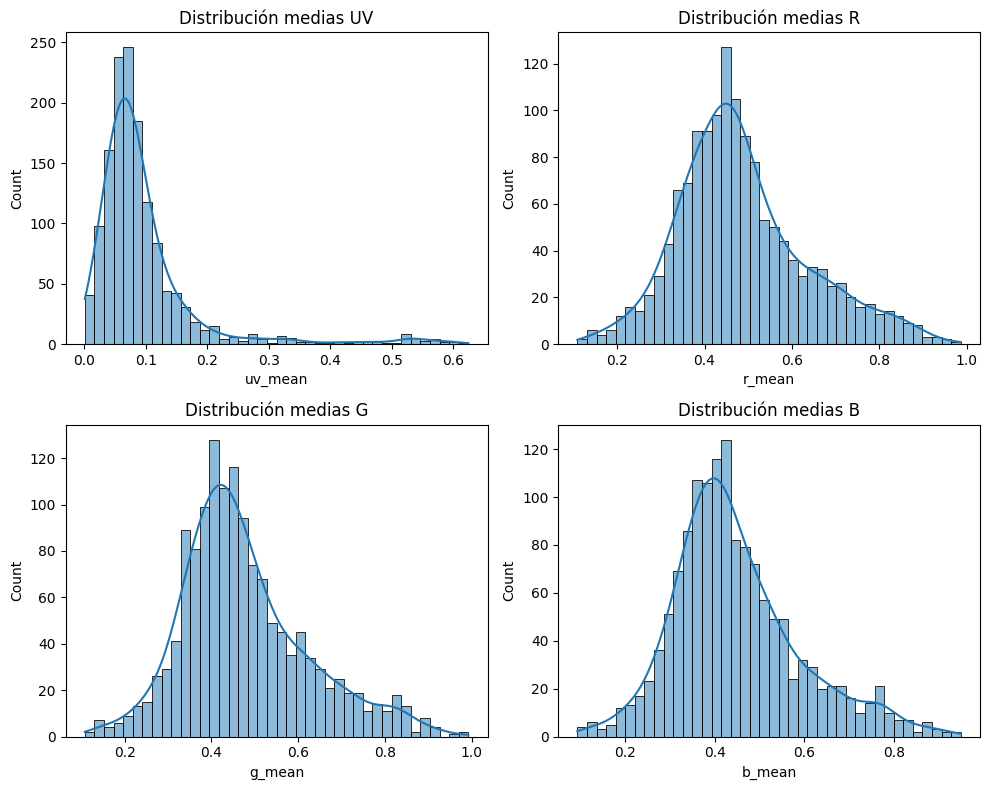

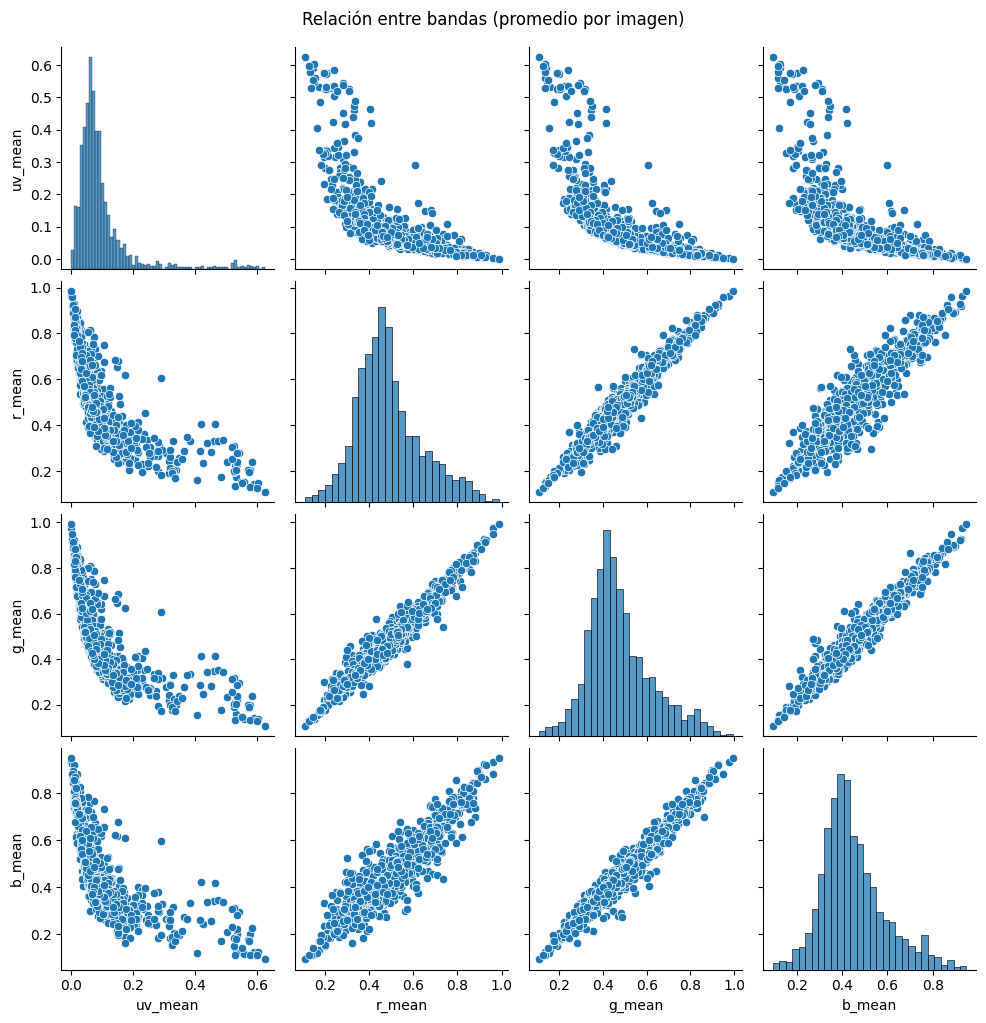

Matriz de correlación (Spearman):
          uv_mean  r_mean  g_mean  b_mean
uv_mean    1.000  -0.875  -0.877  -0.854
r_mean    -0.875   1.000   0.964   0.898
g_mean    -0.877   0.964   1.000   0.966
b_mean    -0.854   0.898   0.966   1.000

PCA:  Silhouette=0.485  DB=0.595  CH=3419.5


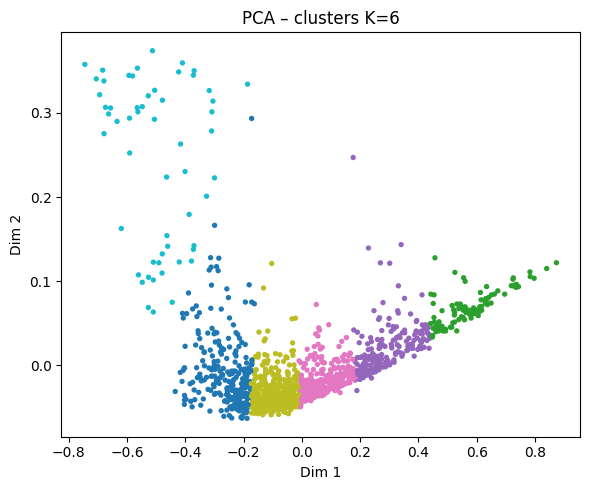


t-SNE:  Silhouette=0.471  DB=0.665  CH=2536.7


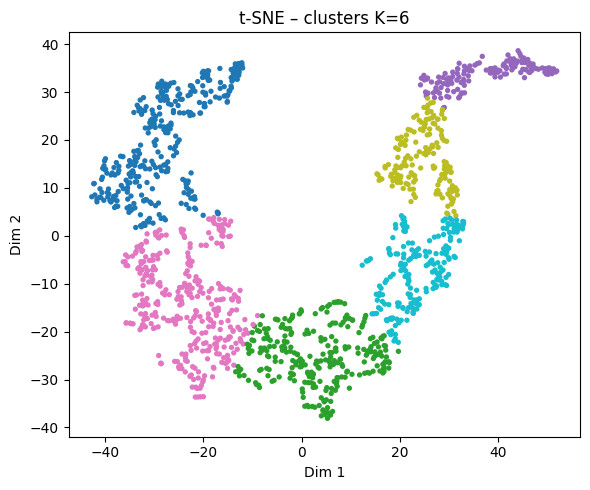

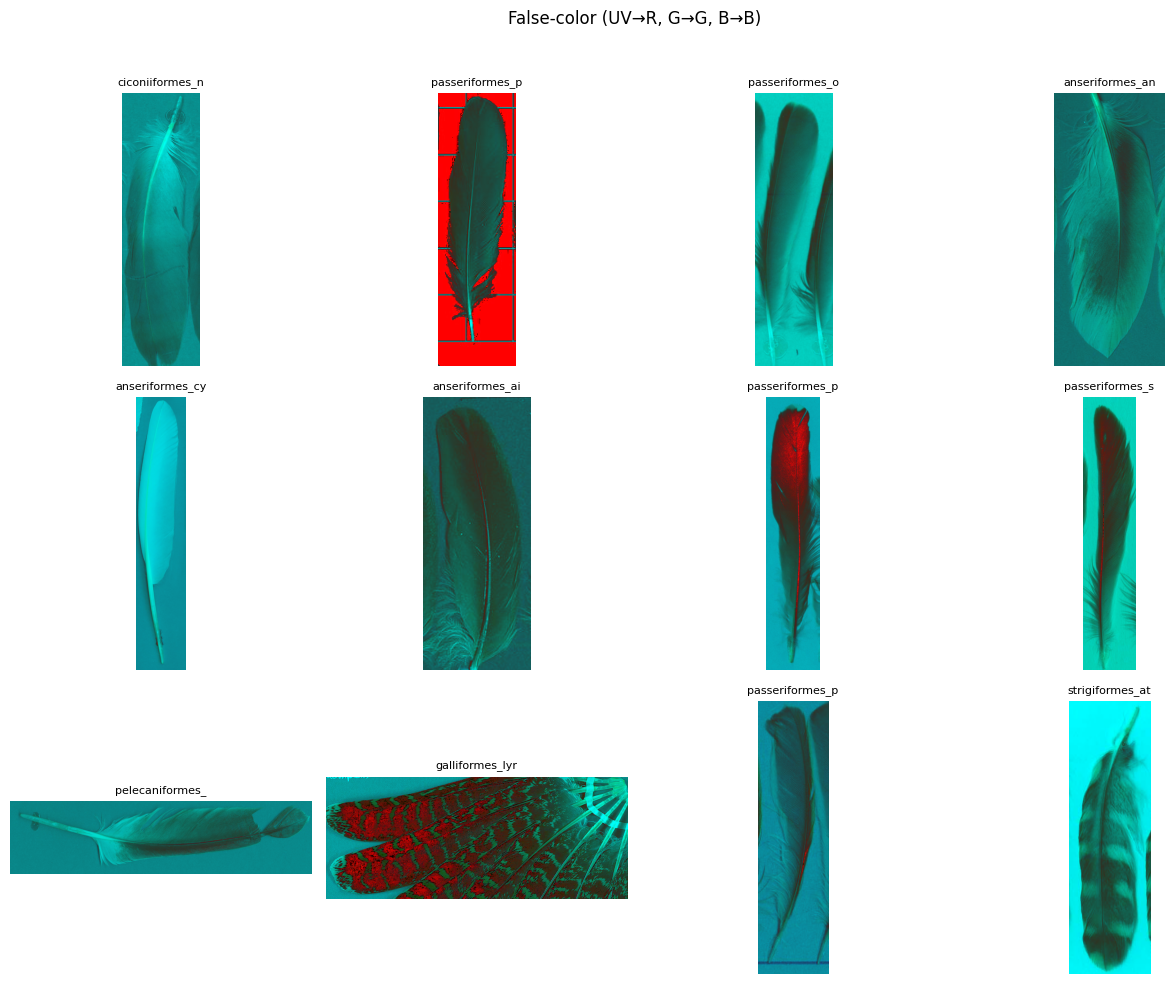

In [20]:
# ================================================================
# 0 · Instalación de dependencias (ejecuta una sola vez)
# ================================================================
!pip install -q tifffile opencv-python numpy pandas matplotlib seaborn scikit-learn tqdm

# ================================================================
# 1 · Configuración de rutas
# ================================================================
from pathlib import Path
import numpy as np, pandas as pd, cv2, tifffile, matplotlib.pyplot as plt, seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm.notebook import tqdm
import random, warnings, os

DST_ROOT = Path("/content/drive/MyDrive/Proyecto_Curso_BEIT_aves/birds_image/feathers/uvb_feathers")
EXT      = ('.tif', '.tiff')                      # solo multicanal
N_PREVIEW= 12
SEED     = 42
random.seed(SEED)
warnings.filterwarnings("ignore")                 # para limpieza visual

# ================================================================
# 2 · Utilidades de carga y validación
# ================================================================
def load_tiff(path):
    """Lee TIFF 16-bit → float32 [0,1] y devuelve (H,W,4) o error."""
    arr = tifffile.imread(path)
    if arr.ndim == 2:             # (H,W) → (H,W,1)
        arr = arr[..., None]
    if arr.shape[-1] != 4:
        raise ValueError(f"{path} tiene {arr.shape[-1]} canales")
    return arr.astype('float32') / 65535.0

def false_color(arr4):
    """UV→R  ·  G→G  ·  B→B  (normalizado + CLAHE opcional)."""
    uv,r,g,b = arr4[...,0], arr4[...,1], arr4[...,2], arr4[...,3]
    fc = np.stack([uv, g, b], axis=-1)
    if fc.max() > 0:
        fc = fc / fc.max()
    return fc.clip(0,1)

def channel_stats(arr4):
    """Devuelve dict con estadísticos por banda."""
    flat = arr4.reshape(-1,4)
    return {
        'uv_mean': flat[:,0].mean(),
        'r_mean':  flat[:,1].mean(),
        'g_mean':  flat[:,2].mean(),
        'b_mean':  flat[:,3].mean(),
        'uv_std':  flat[:,0].std(),
        'uv_max':  flat[:,0].max(),
        'uv_min':  flat[:,0].min(),
    }

# ================================================================
# 3 · Exploración y chequeo de canales
# ================================================================
paths = [p for p in DST_ROOT.rglob("*") if p.suffix.lower() in EXT]

bad_files, meta = [], []
for p in tqdm(paths, desc="Leyendo TIFF"):
    try:
        img4 = load_tiff(p)
        meta.append({'file':str(p), **channel_stats(img4)})
    except Exception as e:
        bad_files.append((p, str(e)))

print(f"\nTotal TIFF encontrados      : {len(paths):,}")
print(f"Con 4 canales válidos       : {len(meta):,}")
print(f"Archivos problemáticos      : {len(bad_files):,}")
if bad_files:
    print("→ revisa 'bad_tiffs.csv' para detalles.")
    pd.DataFrame(bad_files, columns=['file','error']).to_csv("bad_tiffs.csv", index=False)

df = pd.DataFrame(meta)

# ================================================================
# 4 · Histogramas por banda
# ================================================================
fig, axes = plt.subplots(2,2, figsize=(10,8))
for ax, col in zip(axes.ravel(), ['uv','r','g','b']):
    sns.histplot(df[f"{col}_mean"], bins=40, ax=ax, kde=True)
    ax.set_title(f"Distribución medias {col.upper()}")
plt.tight_layout(); plt.show()

# ================================================================
# 5 · Correlación inter-bandas
# ================================================================
sns.pairplot(df[['uv_mean','r_mean','g_mean','b_mean']], kind='scatter')
plt.suptitle("Relación entre bandas (promedio por imagen)", y=1.02); plt.show()
print("Matriz de correlación (Spearman):\n",
      df[['uv_mean','r_mean','g_mean','b_mean']].corr(method='spearman').round(3))

# ================================================================
# 6 · PCA / t-SNE + K-means (k=6)
# ================================================================
features = df[['uv_mean','r_mean','g_mean','b_mean']].to_numpy()
embeddings = {
    'PCA':  PCA(n_components=2, random_state=SEED).fit_transform(features),
    't-SNE':TSNE(n_components=2, perplexity=30, random_state=SEED).fit_transform(features)
}

for name, emb in embeddings.items():
    k = 6
    km = KMeans(n_clusters=k, random_state=SEED).fit(emb)
    sil = silhouette_score(emb, km.labels_)
    db  = davies_bouldin_score(emb, km.labels_)
    ch  = calinski_harabasz_score(emb, km.labels_)
    print(f"\n{name}:  Silhouette={sil:.3f}  DB={db:.3f}  CH={ch:.1f}")
    plt.figure(figsize=(6,5))
    plt.scatter(emb[:,0], emb[:,1], c=km.labels_, s=8, cmap='tab10')
    plt.title(f"{name} – clusters K={k}")
    plt.xlabel("Dim 1"); plt.ylabel("Dim 2"); plt.tight_layout(); plt.show()

# ================================================================
# 7 · Mosaico de pre-visualización
# ================================================================
import math, random
sample_paths = random.sample(paths, min(N_PREVIEW, len(paths)))
cols = 4
rows = math.ceil(len(sample_paths)/cols)
plt.figure(figsize=(3.2*cols, 3.2*rows))
for i,p in enumerate(sample_paths):
    arr4 = load_tiff(p)
    plt.subplot(rows, cols, i+1)
    plt.imshow(false_color(arr4))
    plt.title(p.name[:15], fontsize=8); plt.axis('off')
plt.suptitle("False-color (UV→R, G→G, B→B)", y=1.02)
plt.tight_layout(); plt.show()

 # Curvas espetrales y perfil de ejemplo de las imagenes resultantes

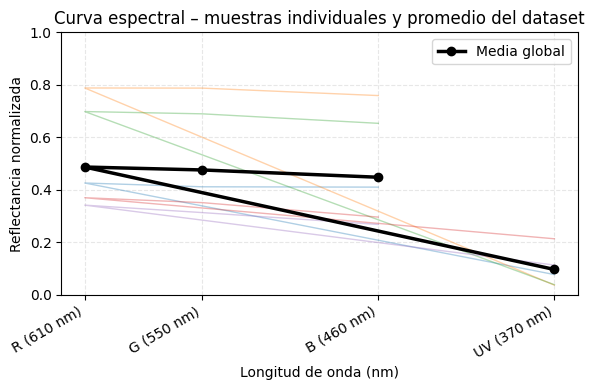

In [21]:
# ================================================================
# 8 · Curvas espectrales de ejemplo y perfil global
# ================================================================
import matplotlib.pyplot as plt
import random
import numpy as np

# Longitudes de onda aproximadas para cada canal [UV, R, G, B]
WAVELENGTHS  = np.array([370, 610, 550, 460])       # nm
WL_ORDER     = ['UV (370 nm)', 'R (610 nm)', 'G (550 nm)', 'B (460 nm)']
COLORS       = ['purple', 'red', 'green', 'blue']   # para barras/flechas opcionales

# --- n imágenes de muestra
N_SPEC_SAMPLES = 5
sample_paths   = random.sample(paths, min(N_SPEC_SAMPLES, len(paths)))

plt.figure(figsize=(6,4))
for p in sample_paths:
    img4   = load_tiff(p)               # (H,W,4) [UV,R,G,B] normalizado 0-1
    means  = img4.reshape(-1,4).mean(0) # media por canal
    plt.plot(WAVELENGTHS, means, alpha=0.35, linewidth=1)

# --- perfil global (media de todo el dataset EDA)
global_means = df[['uv_mean','r_mean','g_mean','b_mean']].mean().to_numpy()
plt.plot(WAVELENGTHS, global_means, color='black', linewidth=2.5,
         label='Media global', marker='o')

plt.gca().invert_xaxis()                             # convencional: UV a la izquierda
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Reflectancia normalizada")
plt.title("Curva espectral – muestras individuales y promedio del dataset")
plt.xticks(WAVELENGTHS, WL_ORDER, rotation=30, ha='right')
plt.ylim(0, 1)
plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


Enriquecimiento de información: ¿qué gana la imagen al agregar un canal UVB “estimado”?
Aunque la imagen original no traiga UV real, el hecho de que añadas el canal UVB predicho por tu regresor (que entrenaste con datos espectrales 300–700 nm) te aporta varios beneficios:

Acceso a patrones ultravioleta “ocultos” en el visible

Muchas plumas reflejan o absorben radiación en UV de forma distinta (invisible al ojo) aun cuando su apariencia RGB sea parecida.

Al incluir el canal UVB (estimado), podrás detectar zonas de la pluma que tienen reflectancia UV relativamente alta o baja aun cuando, en RGB, parezcan uniformes.

Esto sirve para revelar marcas, estrías o contrastes que en la fotografía sólo en visible pasan inadvertidos.

Mayor capacidad de discriminación en tareas de clustering y clasificación

Si dos plumas de especies diferentes tienen tonalidades muy similares en RGB pero se comportan distinto en UV, un modelo o un algoritmo de clustering en 4 dimensiones (R, G, B, UV) logrará separarlas mejor que uno que sólo use (R, G, B).

En el EDA, cuando hagas histogramas o embeddings (p. ej. UMAP, t-SNE) con los cuatro canales, podrías observar grupos nuevos que no existían en el espacio tridimensional RGB.

Posibilidad de visualizar “pseudo-tetrocromía”

Al guardar tus imágenes como TIFF de 4 canales, puedes cargar luego ese TIFF en programas como ImageJ, QGIS o Matplotlib y asignar el canal UVB a una capa de color especial (por ejemplo, “rojo falso” o “magenta”).

De inmediato verás texturas o bordes diferentes, porque comparas los valores numéricos de UVB con R, G y B.

Este “mapeo” puede revelar detalles (puntos reflectantes o manchas UV) que en la imagen original jamás se notaban.

Aumento de la robustez de tus análisis espectrales

Aunque no tengas un espectrómetro para medir UV directamente en campo, tu regresor UV (entrenado con datos espectrales de plumajes) actúa como un puente:

Si el regressor está correctamente validado, su salida en UV (entre 0 y 1) se aproxima bastante a la reflectancia real.

Por eso, al incorporar ese canal, en realidad estás añadiendo información que la cámara visible no capturó, pero que sabes (por datos espectrales previos) que sí existe para cada pixel de pluma.